In [814]:
import pandas as pd
import numpy as np
import os
import wrangle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.pipeline import make_pipeline

In [815]:
def new_zillow_db():
    '''The function uses the get_connection function to connect to a database and retrieve the zillow dataset'''
    
    zillow = pd.read_sql('''SELECT p.bathroomcnt, p.bedroomcnt, p.calculatedfinishedsquarefeet,
    p.fips, p.lotsizesquarefeet, p.regionidcity, p.regionidcounty, p.regionidzip, p.yearbuilt, 
    p.taxvaluedollarcnt, pd.transactiondate, pd.logerror
    FROM properties_2017 as p

    JOIN predictions_2017 as pd
    on p.id = pd.id
    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                              "Inferred Single Family Residential")
    AND pd.transactiondate BETWEEN "2017-01-01" AND "2017-12-31"
    ;''', wrangle.get_connection('zillow'))
    return zillow


In [816]:
df = new_zillow_db()

In [817]:
df

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,transactiondate,logerror
0,0.0,0.0,NaN,6037.0,4083.0,37688.0,3101.0,96337.0,NaN,27516.0,2017-01-01,0.055619
1,0.0,0.0,NaN,6037.0,11975.0,40227.0,3101.0,97329.0,NaN,10.0,2017-01-02,0.008669
2,0.0,0.0,NaN,6037.0,9403.0,40227.0,3101.0,97330.0,NaN,10.0,2017-01-02,-0.021896
3,0.0,0.0,NaN,6037.0,3817.0,40227.0,3101.0,97330.0,NaN,2108.0,2017-01-02,-0.017167
4,2.0,4.0,3633.0,6037.0,9826.0,40227.0,3101.0,97329.0,2005.0,296425.0,2017-01-02,0.042463
...,...,...,...,...,...,...,...,...,...,...,...,...
56074,2.0,2.0,1362.0,6037.0,6854.0,40227.0,3101.0,97330.0,1996.0,127276.0,2017-09-19,0.001082
56075,2.0,3.0,1600.0,6037.0,6709.0,40227.0,3101.0,97330.0,1992.0,180715.0,2017-09-20,-0.002245
56076,3.0,4.0,1921.0,6037.0,6763.0,40227.0,3101.0,97330.0,1990.0,162019.0,2017-09-20,0.020615
56077,3.0,4.0,1780.0,6037.0,6822.0,40227.0,3101.0,97330.0,1989.0,125923.0,2017-09-21,0.013209


In [818]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56079 entries, 0 to 56078
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   56079 non-null  float64
 1   bedroomcnt                    56079 non-null  float64
 2   calculatedfinishedsquarefeet  55848 non-null  float64
 3   fips                          56079 non-null  float64
 4   lotsizesquarefeet             55729 non-null  float64
 5   regionidcity                  55025 non-null  float64
 6   regionidcounty                56079 non-null  float64
 7   regionidzip                   55979 non-null  float64
 8   yearbuilt                     55830 non-null  float64
 9   taxvaluedollarcnt             56071 non-null  float64
 10  transactiondate               56079 non-null  object 
 11  logerror                      56079 non-null  float64
dtypes: float64(11), object(1)
memory usage: 5.1+ MB


In [819]:
df = df.dropna()

In [820]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54553 entries, 4 to 56078
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   54553 non-null  float64
 1   bedroomcnt                    54553 non-null  float64
 2   calculatedfinishedsquarefeet  54553 non-null  float64
 3   fips                          54553 non-null  float64
 4   lotsizesquarefeet             54553 non-null  float64
 5   regionidcity                  54553 non-null  float64
 6   regionidcounty                54553 non-null  float64
 7   regionidzip                   54553 non-null  float64
 8   yearbuilt                     54553 non-null  float64
 9   taxvaluedollarcnt             54553 non-null  float64
 10  transactiondate               54553 non-null  object 
 11  logerror                      54553 non-null  float64
dtypes: float64(11), object(1)
memory usage: 5.4+ MB


In [821]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
count,54553.000000,54553.000000,54553.000000,54553.000000,5.455300e+04,54553.000000,54553.000000,54553.000000,54553.000000,5.455300e+04,54553.000000
mean,2.237686,3.298517,1857.693784,6048.856177,1.123118e+04,35502.566018,2560.631918,96594.523436,1960.796253,4.525896e+05,0.016783
std,0.989100,0.931808,955.170666,21.280432,9.141415e+04,54204.959656,786.841412,4323.250953,21.698743,5.892449e+05,0.172213
min,0.000000,0.000000,20.000000,6037.000000,1.690000e+02,3491.000000,1286.000000,95982.000000,1862.000000,9.000000e+00,-4.655420
25%,2.000000,3.000000,1260.000000,6037.000000,5.686000e+03,12447.000000,2061.000000,96193.000000,1949.000000,1.866290e+05,-0.024437
50%,2.000000,3.000000,1624.000000,6037.000000,6.790000e+03,24832.000000,3101.000000,96389.000000,1958.000000,3.271200e+05,0.006741
75%,3.000000,4.000000,2200.000000,6059.000000,8.600000e+03,44116.000000,3101.000000,96987.000000,1975.000000,5.288470e+05,0.039486
max,20.000000,25.000000,26345.000000,6111.000000,6.971010e+06,396556.000000,3101.000000,399675.000000,2016.000000,3.016684e+07,5.262999


In [822]:
df.bedroomcnt = df.bedroomcnt.astype(int)
    # change year built to an integer
df.yearbuilt = df.yearbuilt.astype(int)
    # change fips to an integer
df.fips = df.fips.astype(int)
    # rename columns for readability
df = df.rename(columns={'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms', 'calculatedfinishedsquarefeet': 'sqft', 
                        'taxvaluedollarcnt': 'tax_value', 'yearbuilt': 'year'})

/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_1750/26307220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bedroomcnt = df.bedroomcnt.astype(int)
/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_1750/26307220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.yearbuilt = df.yearbuilt.astype(int)
/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_1750/26307220.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [823]:
df = df.rename(columns={'lotsizesquarefeet':'lot_size', 'regionidzip':'zipcode','regionidcounty':'county',
                        'regionidcity':'city'})

In [824]:
df

,bathrooms,bedrooms,sqft,fips,lot_size,city,county,zipcode,year,tax_value,transactiondate,logerror
4,2.0,4,3633.0,6037,9826.0,40227.0,3101.0,97329.0,2005,296425.0,2017-01-02,0.042463
7,2.0,3,2077.0,6037,6490.0,26964.0,3101.0,96152.0,1926,646760.0,2017-01-02,-0.040807
11,0.0,0,1200.0,6037,4054.0,12447.0,3101.0,96020.0,1972,5328.0,2017-01-02,0.069858
14,0.0,0,171.0,6037,13002.0,46298.0,3101.0,96246.0,1973,6920.0,2017-01-02,0.020950
15,0.0,0,203.0,6037,17359.0,46298.0,3101.0,96236.0,1960,14166.0,2017-01-02,0.033233
...,...,...,...,...,...,...,...,...,...,...,...,...
56074,2.0,2,1362.0,6037,6854.0,40227.0,3101.0,97330.0,1996,127276.0,2017-09-19,0.001082
56075,2.0,3,1600.0,6037,6709.0,40227.0,3101.0,97330.0,1992,180715.0,2017-09-20,-0.002245
56076,3.0,4,1921.0,6037,6763.0,40227.0,3101.0,97330.0,1990,162019.0,2017-09-20,0.020615
56077,3.0,4,1780.0,6037,6822.0,40227.0,3101.0,97330.0,1989,125923.0,2017-09-21,0.013209


In [825]:
df.describe()

,bathrooms,bedrooms,sqft,fips,lot_size,city,county,zipcode,year,tax_value,logerror
count,54553.000000,54553.000000,54553.000000,54553.000000,5.455300e+04,54553.000000,54553.000000,54553.000000,54553.000000,5.455300e+04,54553.000000
mean,2.237686,3.298517,1857.693784,6048.856177,1.123118e+04,35502.566018,2560.631918,96594.523436,1960.796253,4.525896e+05,0.016783
std,0.989100,0.931808,955.170666,21.280432,9.141415e+04,54204.959656,786.841412,4323.250953,21.698743,5.892449e+05,0.172213
min,0.000000,0.000000,20.000000,6037.000000,1.690000e+02,3491.000000,1286.000000,95982.000000,1862.000000,9.000000e+00,-4.655420
25%,2.000000,3.000000,1260.000000,6037.000000,5.686000e+03,12447.000000,2061.000000,96193.000000,1949.000000,1.866290e+05,-0.024437
50%,2.000000,3.000000,1624.000000,6037.000000,6.790000e+03,24832.000000,3101.000000,96389.000000,1958.000000,3.271200e+05,0.006741
75%,3.000000,4.000000,2200.000000,6059.000000,8.600000e+03,44116.000000,3101.000000,96987.000000,1975.000000,5.288470e+05,0.039486
max,20.000000,25.000000,26345.000000,6111.000000,6.971010e+06,396556.000000,3101.000000,399675.000000,2016.000000,3.016684e+07,5.262999


In [826]:
df = df[df['bedrooms'] < 5]
#     # remove rows with 6 or more bathrooms
df = df[df['bathrooms'] < 4]
#     # remove rows with values less than or equal to 700 square feet
df = df[df.sqft > 700]
#     # remove rows with values greater than or equal to 10_000 square feet
# df = df[df.sqft < 3000]
# remove rows with tax values greater than or equal to 600000
df = df[df.tax_value < 600000]
# remove rows with tax values less than or equal to 1000
df = df[df.tax_value > 100000]
#     # remove rows with a year less than or equal to 1899
# df = df[df.year > 1899]
df = df[df.bathrooms > 0]
df = df[df.bedrooms > 0]

In [827]:
df = df[df.lot_size < 10000]
df = df[df.lot_size > 1000]

(array([2973., 3685., 4415., 4038., 3457., 3113., 2723., 2231., 1647.,
        1333.]),
 array([100002. , 149985.1, 199968.2, 249951.3, 299934.4, 349917.5,
        399900.6, 449883.7, 499866.8, 549849.9, 599833. ]),
 <BarContainer object of 10 artists>)

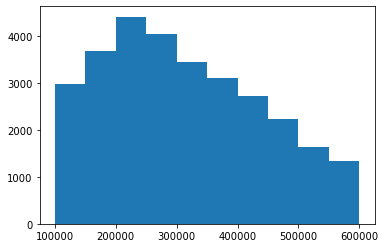

In [828]:
plt.hist(df.tax_value)

(array([ 427.,  580.,  942., 1257., 4817., 7341., 6425., 4561., 2043.,
        1222.]),
 array([1010. , 1908.9, 2807.8, 3706.7, 4605.6, 5504.5, 6403.4, 7302.3,
        8201.2, 9100.1, 9999. ]),
 <BarContainer object of 10 artists>)

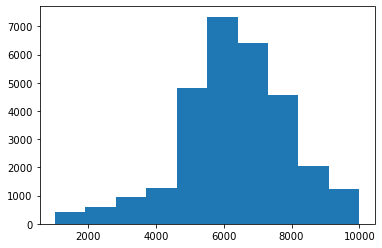

In [829]:
plt.hist(df.lot_size)

In [830]:
df.describe()

,bathrooms,bedrooms,sqft,fips,lot_size,city,county,zipcode,year,tax_value,logerror
count,29615.000000,29615.000000,29615.000000,29615.000000,29615.000000,29615.000000,29615.000000,29615.000000,29615.000000,29615.000000,29615.000000
mean,1.950498,3.089819,1536.212865,6048.404829,6334.737565,36145.993922,2578.436603,96530.208611,1958.520142,312246.796353,0.016336
std,0.637437,0.695310,476.923989,20.944447,1604.984969,55952.684548,780.275872,405.694422,20.158898,128165.296735,0.170316
min,1.000000,1.000000,702.000000,6037.000000,1010.000000,3491.000000,1286.000000,95982.000000,1880.000000,100002.000000,-4.655420
25%,2.000000,3.000000,1196.000000,6037.000000,5409.000000,12447.000000,2061.000000,96193.000000,1949.000000,208718.000000,-0.024645
50%,2.000000,3.000000,1457.000000,6037.000000,6325.000000,24812.000000,3101.000000,96389.000000,1956.000000,296302.000000,0.006654
75%,2.000000,4.000000,1799.000000,6059.000000,7382.500000,44833.000000,3101.000000,96990.000000,1971.000000,409000.000000,0.039265
max,3.500000,4.000000,4314.000000,6111.000000,9999.000000,396556.000000,3101.000000,97330.000000,2015.000000,599833.000000,3.394544


In [831]:
df = df.drop(columns=['zipcode','city','transactiondate','logerror'])

In [832]:
train, validate, test = wrangle.split_data(df)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bedrooms', ylabel='count'>

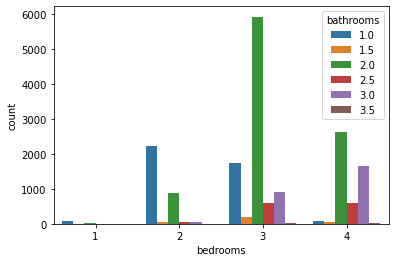

In [833]:
sns.countplot(train.bedrooms, hue=train.bathrooms)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fips', ylabel='count'>

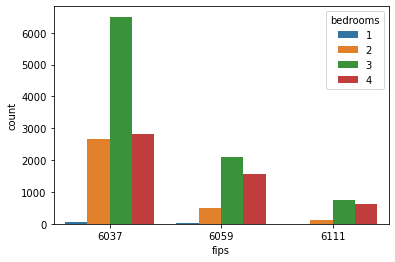

In [834]:
sns.countplot(train.fips, hue=train.bedrooms)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqft', ylabel='lot_size'>

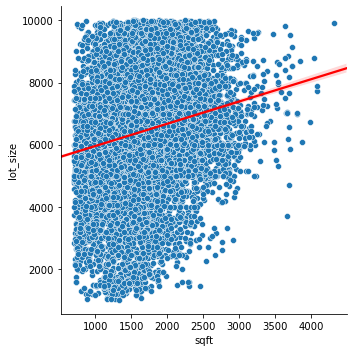

In [835]:
sns.relplot(train.sqft, train.lot_size)
sns.regplot(x='sqft', y='lot_size', data=train, truncate=False, scatter=False, color='red')

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqft', ylabel='tax_value'>

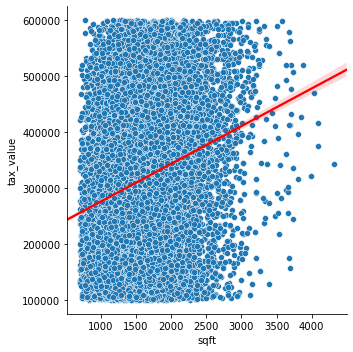

In [836]:
sns.relplot(train.sqft, train.tax_value)
sns.regplot(x='sqft', y='tax_value', data=train, truncate=False, scatter=False, color='red')

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lot_size', ylabel='tax_value'>

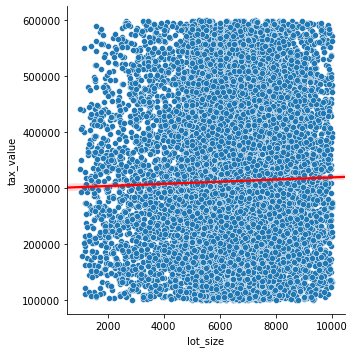

In [837]:
sns.relplot(train.lot_size, train.tax_value)
sns.regplot(x='lot_size', y='tax_value', data=train, truncate=False, scatter=False, color='red')

In [838]:
cols = ['bathrooms','bedrooms','sqft']
X_train, y_train = train[cols], train.tax_value
X_validate, y_validate = validate[cols], validate.tax_value
X_test, y_test = test[cols], test.tax_value

In [839]:
baseline = train.tax_value.mean()

In [840]:
train['baseline'] = baseline

In [841]:
train

,bathrooms,bedrooms,sqft,fips,lot_size,county,year,tax_value,baseline
44874,2.0,3,1160.0,6037,7496.0,3101.0,1969,379703.0,312117.110755
41628,1.0,3,933.0,6059,7389.0,1286.0,1945,191541.0,312117.110755
10598,3.0,4,2112.0,6037,8530.0,3101.0,2006,185680.0,312117.110755
22856,2.0,3,1701.0,6037,6431.0,3101.0,1955,115932.0,312117.110755
22666,2.0,3,1266.0,6037,6890.0,3101.0,1950,334587.0,312117.110755
...,...,...,...,...,...,...,...,...,...
1073,2.0,2,1363.0,6037,5274.0,3101.0,1956,204720.0,312117.110755
3291,1.0,1,714.0,6037,4157.0,3101.0,1936,467351.0,312117.110755
40567,2.0,3,1323.0,6059,8125.0,1286.0,1963,489553.0,312117.110755
44556,1.0,3,1548.0,6037,5520.0,3101.0,1928,200990.0,312117.110755


In [842]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.minmax_scaler(X_train, X_validate, X_test)

In [843]:
ols_model = LinearRegression().fit(X_train_scaled, train.tax_value)

In [844]:
train['yhat'] = ols_model.predict(X_train_scaled)

In [845]:
y = train.tax_value
yhat = train.yhat

In [846]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [847]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [848]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  2.718157e+14
1    MSE  1.529719e+10
2   RMSE  1.236818e+05
          metric   model_error
0   SSE_baseline  2.910802e+14
1   MSE_baseline  1.638135e+10
2  RMSE_baseline  1.279896e+05


In [849]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,2.718157e+14,-1.926449e+13
1,MSE,1.529719e+10,-1.084163e+09
2,RMSE,1.236818e+05,-4.307851e+03


In [850]:
r2_score(train.tax_value, train.yhat)

0.0661827757346789

In [851]:
cols = ['bathrooms','sqft','year','fips']
X_train, y_train = train[cols], train.tax_value
X_validate, y_validate = validate[cols], validate.tax_value
X_test, y_test = test[cols], test.tax_value

In [852]:
baseline = train.tax_value.mean()

In [853]:
train['baseline'] = baseline
validate['baseline'] = validate.tax_value.mean()

In [854]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.minmax_scaler(X_train, X_validate, X_test)

In [855]:
ols_model = LinearRegression().fit(X_train_scaled, train.tax_value)

In [856]:
train['yhat'] = ols_model.predict(X_train_scaled)

In [857]:
y = train.tax_value
yhat = train.yhat

In [858]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [859]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [860]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  2.697174e+14
1    MSE  1.517910e+10
2   RMSE  1.232035e+05
          metric   model_error
0   SSE_baseline  2.910802e+14
1   MSE_baseline  1.638135e+10
2  RMSE_baseline  1.279896e+05


In [861]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,2.697174e+14,-2.136281e+13
1,MSE,1.517910e+10,-1.202252e+09
2,RMSE,1.232035e+05,-4.786165e+03


In [862]:
r2_score(train.tax_value, train.yhat)

0.07339150332853817

In [863]:
df.fips = df.fips.astype(str)

In [864]:
df.county = df.county.astype(str)

In [865]:
# create dummies for the 'day' and 'time' columns
dummy_df = pd.get_dummies(df[['fips', 'county']], dummy_na=False)
# concatenate the dummy columns and the original dataframe
df = pd.concat([df, dummy_df], axis=1)

In [62]:
df

,bathrooms,bedrooms,sqft,fips,lot_size,county,year,tax_value,fips_6037,fips_6059,fips_6111,county_1286.0,county_2061.0,county_3101.0
4,2.0,4,3633.0,6037,9826.0,3101.0,2005,296425.0,1,0,0,0,0,1
18,1.0,3,1244.0,6037,6021.0,3101.0,1950,169471.0,1,0,0,0,0,1
19,2.0,3,1300.0,6037,4917.0,3101.0,1950,233266.0,1,0,0,0,0,1
20,2.0,3,1222.0,6037,5500.0,3101.0,1951,290492.0,1,0,0,0,0,1
23,2.5,3,1821.0,6059,2442.0,1286.0,2013,537949.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56074,2.0,2,1362.0,6037,6854.0,3101.0,1996,127276.0,1,0,0,0,0,1
56075,2.0,3,1600.0,6037,6709.0,3101.0,1992,180715.0,1,0,0,0,0,1
56076,3.0,4,1921.0,6037,6763.0,3101.0,1990,162019.0,1,0,0,0,0,1
56077,3.0,4,1780.0,6037,6822.0,3101.0,1989,125923.0,1,0,0,0,0,1


In [63]:
df['bed_bath'] = df.bathrooms + df.bedrooms

In [64]:
df.fips = df.fips.astype(int)

In [66]:
df.county = df.county.astype(float)

In [67]:
train, validate, test = wrangle.split_data(df)

In [68]:
train.describe()

,bathrooms,bedrooms,sqft,fips,lot_size,county,year,tax_value,fips_6037,fips_6059,fips_6111,county_1286.0,county_2061.0,county_3101.0,bed_bath
count,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000,17769.000000
mean,1.945354,3.087737,1536.558557,6048.476391,6341.957904,2583.193427,1958.425685,312117.110755,0.678541,0.236761,0.084698,0.236761,0.084698,0.678541,5.033091
std,0.634975,0.693372,477.561281,21.135666,1597.650056,776.828553,19.976436,127993.244482,0.467050,0.425106,0.278440,0.425106,0.278440,0.467050,1.168313
min,1.000000,1.000000,702.000000,6037.000000,1010.000000,1286.000000,1880.000000,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2.000000,3.000000,1196.000000,6037.000000,5421.000000,2061.000000,1949.000000,208332.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,2.000000,3.000000,1458.000000,6037.000000,6327.000000,3101.000000,1956.000000,296585.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000
75%,2.000000,4.000000,1800.000000,6059.000000,7389.000000,3101.000000,1971.000000,408353.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000
max,3.500000,4.000000,4314.000000,6111.000000,9999.000000,3101.000000,2015.000000,599833.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.500000


In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17769 entries, 44874 to 33389
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bathrooms      17769 non-null  float64
 1   bedrooms       17769 non-null  int64  
 2   sqft           17769 non-null  float64
 3   fips           17769 non-null  int64  
 4   lot_size       17769 non-null  float64
 5   county         17769 non-null  float64
 6   year           17769 non-null  int64  
 7   tax_value      17769 non-null  float64
 8   fips_6037      17769 non-null  uint8  
 9   fips_6059      17769 non-null  uint8  
 10  fips_6111      17769 non-null  uint8  
 11  county_1286.0  17769 non-null  uint8  
 12  county_2061.0  17769 non-null  uint8  
 13  county_3101.0  17769 non-null  uint8  
 14  bed_bath       17769 non-null  float64
dtypes: float64(6), int64(3), uint8(6)
memory usage: 1.5 MB


In [737]:
cols = ['bathrooms','sqft','fips_6037','bed_bath','bedrooms','lot_size','year']
X_train, y_train = train[cols], train[['tax_value']]
X_validate, y_validate = validate[cols], validate[['tax_value']]
X_test, y_test = test[cols], test[['tax_value']]

In [738]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.quantile_scaler(X_train, X_validate, X_test)

In [739]:
baseline = train.tax_value.mean()

In [740]:
train['baseline'] = baseline

In [741]:
validate['baseline'] = validate.tax_value.mean()

In [742]:
ols_model = LinearRegression().fit(X_train_scaled, train.tax_value)

In [743]:
train['yhat'] = ols_model.predict(X_train_scaled)

In [744]:
y = train.tax_value
yhat = train.yhat

In [745]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [746]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [747]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  2.674299e+14
1    MSE  1.505036e+10
2   RMSE  1.226799e+05
          metric   model_error
0   SSE_baseline  2.910802e+14
1   MSE_baseline  1.638135e+10
2  RMSE_baseline  1.279896e+05


In [748]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,2.674299e+14,-2.365031e+13
1,MSE,1.505036e+10,-1.330987e+09
2,RMSE,1.226799e+05,-5.309728e+03


In [749]:
r2_score(train.tax_value, train.yhat)

0.08125016405790919

In [750]:
X = X_train
y = y_train

In [751]:
def select_kbest(X, y, k=2):
    '''
    will take in two pandas objects:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of ideal features we elect to select
    
    return: a list of the selected features from the SelectKBest process
    '''
    kbest = SelectKBest(f_regression, k=k)
    kbest.fit(X, y)
    mask = kbest.get_support()
    return X.columns[mask]

In [752]:
select_kbest(X, y, k=5)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Index(['bathrooms', 'sqft', 'fips_6037', 'bed_bath', 'year'], dtype='object')

In [753]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_lars)**(1/2)

# predict validate
y_validate['tax_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  122686.20898600366 
Validation/Out-of-Sample:  124204.50592545512


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_1750/1373569168.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [754]:
train['yhat'] = lars.predict(X_train_scaled)

In [755]:
y = train.tax_value
yhat = train.yhat

In [756]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [757]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [758]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  2.674573e+14
1    MSE  1.505191e+10
2   RMSE  1.226862e+05
          metric   model_error
0   SSE_baseline  2.910802e+14
1   MSE_baseline  1.638135e+10
2  RMSE_baseline  1.279896e+05


In [759]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,2.674573e+14,-2.362287e+13
1,MSE,1.505191e+10,-1.329443e+09
2,RMSE,1.226862e+05,-5.303434e+03


In [760]:
r2_score(train.tax_value, train.yhat)

0.08115588197376433

In [761]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [762]:
# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  119968.49900693612 
Validation/Out-of-Sample:  121664.07661132184


/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_1750/945662987.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)
/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_1750/945662987.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)


In [763]:
train['yhat'] = lm2.predict(X_train_degree2)

In [764]:
y = train.tax_value
yhat = train.yhat

In [765]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [766]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  2.557393e+14
1    MSE  1.439244e+10
2   RMSE  1.199685e+05
          metric   model_error
0   SSE_baseline  2.910802e+14
1   MSE_baseline  1.638135e+10
2  RMSE_baseline  1.279896e+05


In [767]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,2.557393e+14,-3.534090e+13
1,MSE,1.439244e+10,-1.988908e+09
2,RMSE,1.199685e+05,-8.021144e+03


In [768]:
r2_score(train.tax_value, train.yhat)

0.12141295326037349

In [687]:
# create the model object
glm = TweedieRegressor(power=2, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_glm)**(1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=2 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=2 & alpha=0
Training/In-Sample:  122656.24466940804 
Validation/Out-of-Sample:  124241.50593323311


/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_1750/2010277656.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['value_pred_glm'] = glm.predict(X_train_scaled)
/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_1750/2010277656.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_validate['value_pred_glm'] = glm.predict(X_validate_scaled)


In [688]:
train['yhat'] = glm.predict(X_train_scaled)

In [689]:
y = train.tax_value
yhat = train.yhat

In [690]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [691]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  2.673267e+14
1    MSE  1.504455e+10
2   RMSE  1.226562e+05
          metric   model_error
0   SSE_baseline  2.910802e+14
1   MSE_baseline  1.638135e+10
2  RMSE_baseline  1.279896e+05


In [692]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,2.673267e+14,-2.375350e+13
1,MSE,1.504455e+10,-1.336794e+09
2,RMSE,1.226562e+05,-5.333398e+03


In [693]:
r2_score(train.tax_value, train.yhat)

0.081604655704275

In [694]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [695]:
ols_model = LinearRegression().fit(X_validate_scaled, validate.tax_value)

In [696]:
validate['yhat'] = ols_model.predict(X_validate_scaled)

In [697]:
y = validate.tax_value
yhat = validate.yhat

In [698]:
# create column for model residual error
validate['residual'] = validate.yhat - validate.tax_value
# create column for baseline residual error
validate['residual_baseline'] = validate.baseline - validate.tax_value

In [699]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(validate.tax_value, validate.yhat)*len(validate)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(validate.tax_value, validate.baseline)*len(validate)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(validate.tax_value, validate.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(validate.tax_value, validate.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(validate.tax_value, validate.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(validate.tax_value, validate.baseline))

In [700]:
# create a dataframe for the model SSE, MSE, RMSE
e_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
e_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(e_eval)
print(baseline_eval)

  metric   model_error
0    SSE  9.127138e+13
1    MSE  1.540965e+10
2   RMSE  1.241356e+05
          metric   model_error
0   SSE_baseline  9.889407e+13
1   MSE_baseline  1.669662e+10
2  RMSE_baseline  1.292154e+05


In [701]:
# add a column to train_eval for the error delta for each metric
e_eval['error_delta'] = e_eval.model_error - baseline_eval.model_error
e_eval

,metric,model_error,error_delta
0,SSE,9.127138e+13,-7.622693e+12
1,MSE,1.540965e+10,-1.286965e+09
2,RMSE,1.241356e+05,-5.079770e+03


In [702]:
r2_score(validate.tax_value, validate.yhat)

0.07707937290192712

In [703]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_lars)**(1/2)

# predict validate
y_validate['tax_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  122686.20898600366 
Validation/Out-of-Sample:  124204.50592545512


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_1750/1373569168.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [704]:
train['yhat'] = lars.predict(X_train_scaled)

In [705]:
y = train.tax_value
yhat = train.yhat

In [706]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [707]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [708]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  2.674573e+14
1    MSE  1.505191e+10
2   RMSE  1.226862e+05
          metric   model_error
0   SSE_baseline  2.910802e+14
1   MSE_baseline  1.638135e+10
2  RMSE_baseline  1.279896e+05


In [709]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,2.674573e+14,-2.362287e+13
1,MSE,1.505191e+10,-1.329443e+09
2,RMSE,1.226862e+05,-5.303434e+03


In [710]:
r2_score(train.tax_value, train.yhat)

0.08115588197376433